# 1.세팅

In [4]:
!pip install sounddevice

     ---------------------------------------- 0.0/199.7 kB ? eta -:--:--
     ----------- --------------------------- 61.4/199.7 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 199.7/199.7 kB 3.0 MB/s eta 0:00:00


In [6]:
import os
import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io.wavfile
import sounddevice as sd
from ast import literal_eval
import IPython.display as ipd
from matplotlib import rcParams
import matplotlib.pyplot as plt
from IPython.display import Audio
# from IPython.core.display import display
%matplotlib inline

import pandas as pd
pd.set_option('display.max_colwidth', None)


In [2]:
# 한글 환경 설정
def setting_styles_basic():
    rcParams['font.family'] = 'Malgun Gothic' # Windows
    # rcParams['font.family'] = 'AppleGothic' # Mac
    rcParams['axes.unicode_minus'] = False # 한글 폰트 사용 시, 마이너스 기호가 깨지는 현상 방지
    # 경고창 무시
    warnings.filterwarnings('ignore')

setting_styles_basic()

NameError: name 'rcParams' is not defined

In [3]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',   # 매체: paper, talk, poster
              style='darkgrid',     # 기본 내장 테마
              palette='deep',       # 그래프 색
              font='Malgun Gothic', # 글꼴 종류 
              font_scale=0.6,         # 글꼴 크기
              rc=custom_params)     # 그래프 세부 사항

NameError: name 'sns' is not defined

In [10]:
song = pd.read_csv("C:/Users/Ahn/projects/upsing/data/song.csv",converters={"sec":literal_eval}) # sec이 string으로 인식돼서 converters랑 literal_eval이 필요했음
# song.to_csv("C:/Users/Ahn/projects/upsing/song4.csv", index = False,encoding='utf-8-sig')
# song = pd.read_csv("C:/Users/Ahn/projects/upsing/song4.csv", encoding='utf-8-sig')

# 2. label 갯수 EDA

In [5]:
song.head()

,sec,label,song_name,ly,pronunciation,audio_arr
0,"[24.67, 25.5]",비브라토,Christina_Perri_A_Thousand_Years_2,colors,NaN,[-0.0078887939453125 -0.0103912353515625 -0.01...
1,"[26.04, 28.32]",비브라토,Christina_Perri_A_Thousand_Years_2,promise,NaN,[-0.0004119873046875 -0.0033416748046875 -0.00...
2,"[30.98, 31.91]",비브라토,Christina_Perri_A_Thousand_Years_2,brave,NaN,[0.0461273193359375 0.035125732421875 0.029174...
3,"[33.66, 34.42]",비브라토,Christina_Perri_A_Thousand_Years_2,love,NaN,[0.151153564453125 0.1494140625 0.1455078125 ....
4,"[35.0, 36.03]",비브라토,Christina_Perri_A_Thousand_Years_2,i'm,NaN,[0.0457611083984375 0.0686187744140625 0.07807...


In [6]:
song['label'].value_counts()

비브라토      1103
보컬프라이      387
가성         227
믹스드보이스     201
발음         170
벨팅         166
흉성         112
비성         102
두성           6
Name: label, dtype: int64

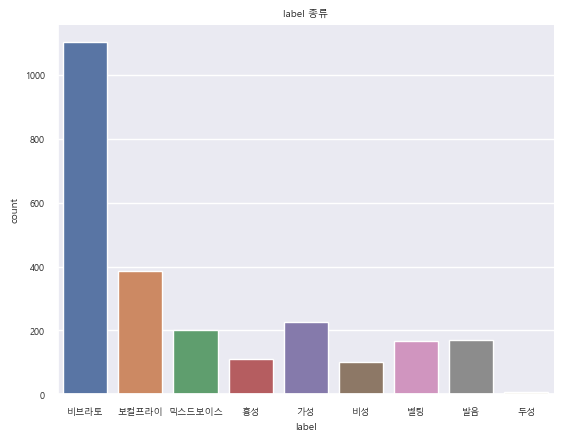

In [7]:
sns.countplot(data = song, x = "label")
plt.title("label 종류")
plt.show()

In [8]:
labels = song['label'].unique()

In [9]:
sec_length = []
cnt_labels = []
for i in labels:
    length, cnt = 0,0
    for idx in song[song['label'] == i].index:
        arr = song.loc[idx,'sec']
        length += arr[1] - arr[0]
        cnt += 1
    sec_length.append(length)
    cnt_labels.append(cnt)
sec_length

[1316.4400000000023,
 155.75,
 412.39999999999964,
 147.76000000000005,
 337.88999999999965,
 213.1,
 434.65999999999985,
 175.12999999999985,
 21.130000000000024]

각 레이블 별 길이의 합


<BarContainer object of 9 artists>

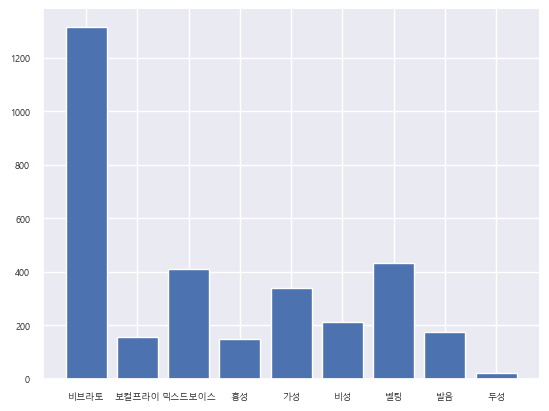

In [10]:
print("각 레이블 별 길이의 합")
plt.bar(labels, sec_length)

각 레이블 별 길이의 평균


<BarContainer object of 9 artists>

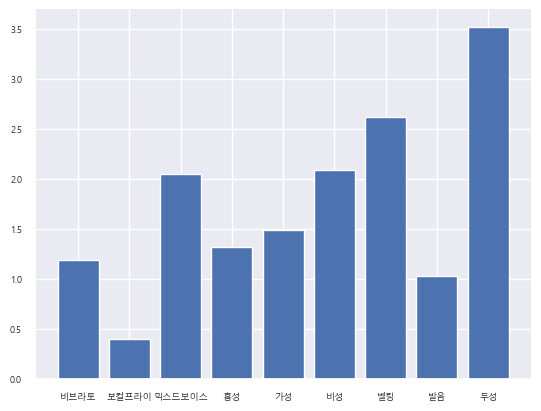

In [11]:
print("각 레이블 별 길이의 평균")
plt.bar(labels, np.array(sec_length) / np.array(cnt_labels))

# 2.5 데이터 EDA를 위해 오디오 배열 추가 + PEAK and LOUDNESS 정규화 된 데이터도 추가

In [11]:
sr = 44100
path = "C:/Users/Ahn/projects/upsing/copy_song_mr_removed/"
filenames = os.listdir(path)

def split_wav(data, sample_rate, start, end):
    start *= sample_rate
    end *= sample_rate
    return data[int(start):int(end)]

In [ ]:
import pyloudnorm as pyln
# 아래는 예시 코드
'''
**Loudness normalization addresses the issue of varying loudness levels when playing multiple songs sequentially. Prior to loudness normalization, one song in a playlist might be quieter than the others, forcing the listener to adjust the volume repeatedly.**

# measure the loudness first 
meter = pyln.Meter(rate) # create BS.1770 meter
loudness = meter.integrated_loudness(data)

# loudness normalize audio to -12 dB LUFS
loudness_normalized_audio = pyln.normalize.loudness(data, loudness, -12.0)
'''

'\n**Loudness normalization addresses the issue of varying loudness levels when playing multiple songs sequentially. Prior to loudness normalization, one song in a playlist might be quieter than the others, forcing the listener to adjust the volume repeatedly.**\n\n# measure the loudness first \nmeter = pyln.Meter(rate) # create BS.1770 meter\nloudness = meter.integrated_loudness(data)\n\n# loudness normalize audio to -12 dB LUFS\nloudness_normalized_audio = pyln.normalize.loudness(data, loudness, -12.0)\n'

In [12]:
# song['audio_arr'] = np.NaN
for file in filenames:
    data, rate = librosa.load(path + file, sr=sr)
    
    for idx in song[song['song_name'] == file[:-4]].index:
        trunc_data = split_wav(data, sr, song.loc[idx, 'sec'][0],song.loc[idx, 'sec'][1])
        trunc_data = list(map(float, trunc_data))
        song.at[idx, 'audio_arr'] = np.array(trunc_data, dtype = object)

#### 서버를 위한 벨팅 배열 예시 저장

In [19]:
tmp = song[song['label']=='벨팅'].iloc[0]['audio_arr']

In [30]:
import numpy as np
np.savetxt("C:/Users/Ahn/projects/upsing/data/teq_example.txt", [tmp], header='벨팅', delimiter = ',')

#### 서버를 위한 믹스드보이스배열 예시 저장

In [32]:
tmp = song[song['label']=='믹스드보이스'].iloc[0]['audio_arr']

In [33]:
import numpy as np
np.savetxt("C:/Users/Ahn/projects/upsing/data/voc_example.txt", [tmp], header='믹스드보이스', delimiter = ',')

#### 정규화

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(song['audio_arr'].values)

ValueError: setting an array element with a sequence.

In [24]:
song['audio_arr'].isnull().any()


False

In [25]:
song.to_csv("C:/Users/Ahn/projects/upsing/song.csv", index = False,encoding='utf-8-sig')

# 3. 데이터 spectrogram으로 비교

In [26]:
teq = ["비브라토", "보컬프라이", "벨팅"]
voc = ["믹스드보이스", "흉성", "가성", "비성"]

In [27]:
teq_audio = []
normed_teq_audio = []
for i in teq:
    teq_audio.append(np.array(song.loc[song['label'] == i, "audio_arr"]))
    normed_teq_audio.append(np.array(song.loc[song['label'] == i, "loudness_normalized_audio_arr"]))
    
voc_audio = []
normed_voc_audio = []
for i in voc:
    voc_audio.append(np.array(song.loc[song['label'] == i, "audio_arr"]))

In [218]:
def show_spec(data, name, x_axis = 'time'):
  librosa.display.specshow(data, sr = 44100, x_axis = x_axis)
  plt.title(name)
  plt.tight_layout()
  plt.show() 

### 1) Wave

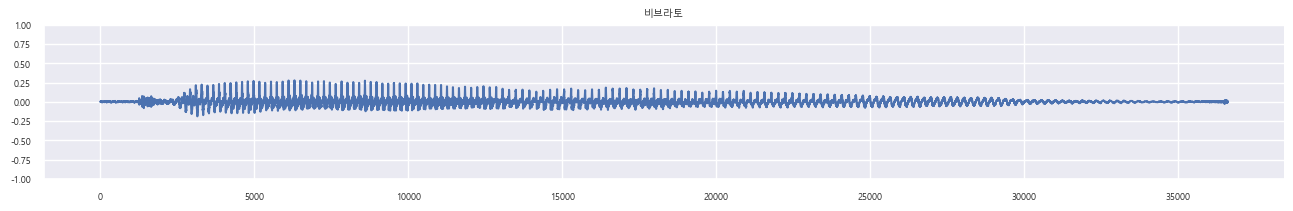

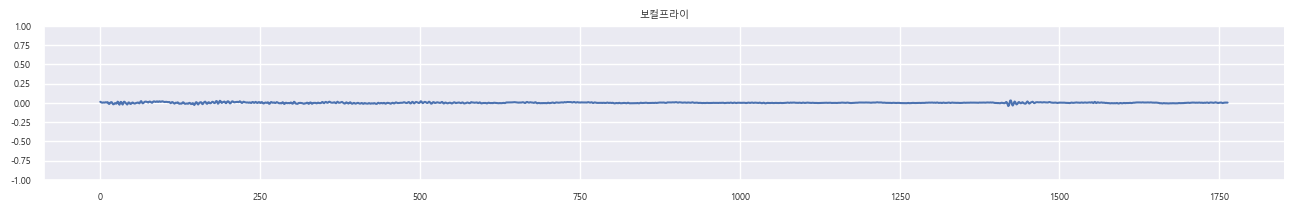

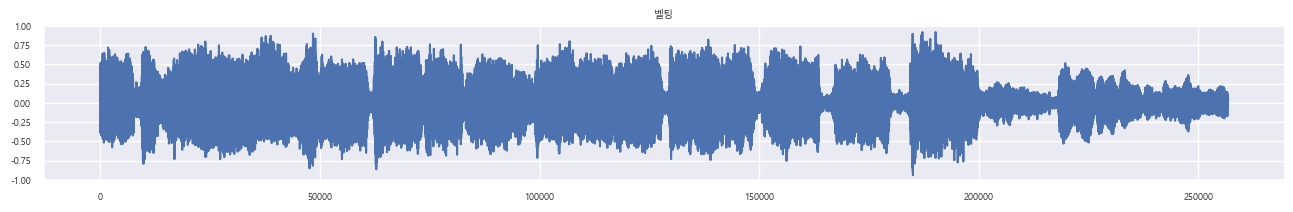

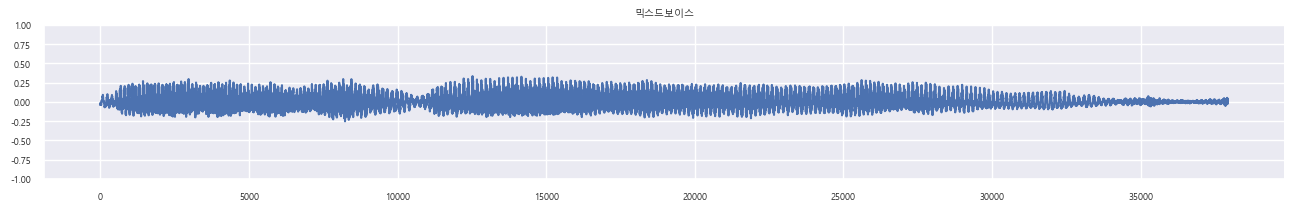

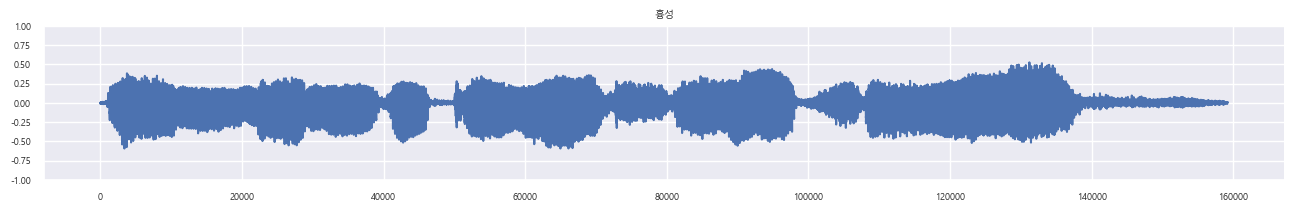

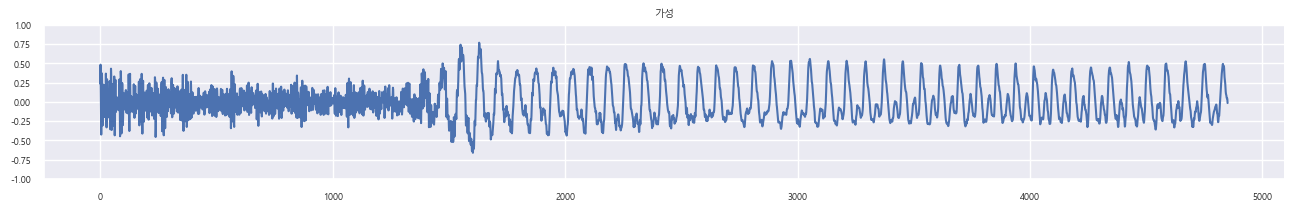

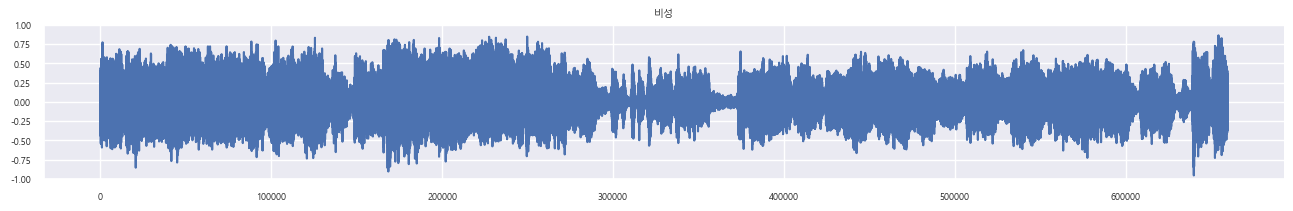

In [219]:
def show_wave(name, data):
  plt.figure(figsize=(16, 2))
  plt.title(name)
  plt.plot(data)
  plt.ylim((-1, 1))
  plt.show()

idx = 10

for name,arr in zip(teq,teq_audio):
    show_wave(name, arr[idx])
print("="*30)
for name,arr in zip(voc,voc_audio):
    show_wave(name, arr[idx])

### 2) STFT

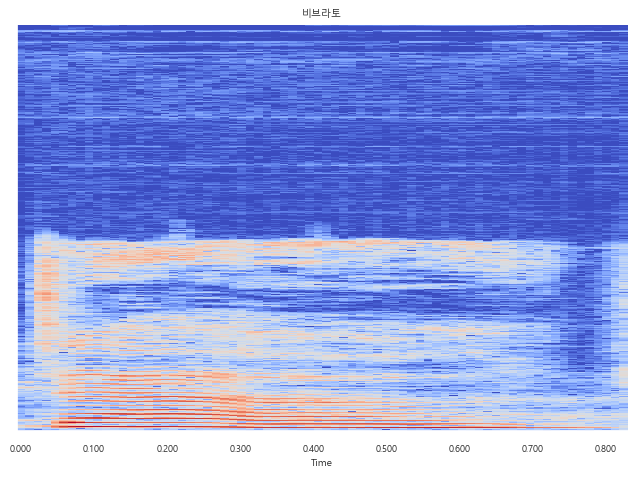

----------


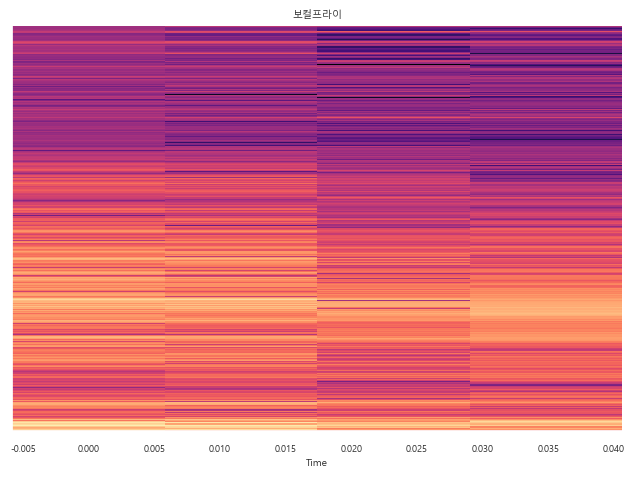

----------


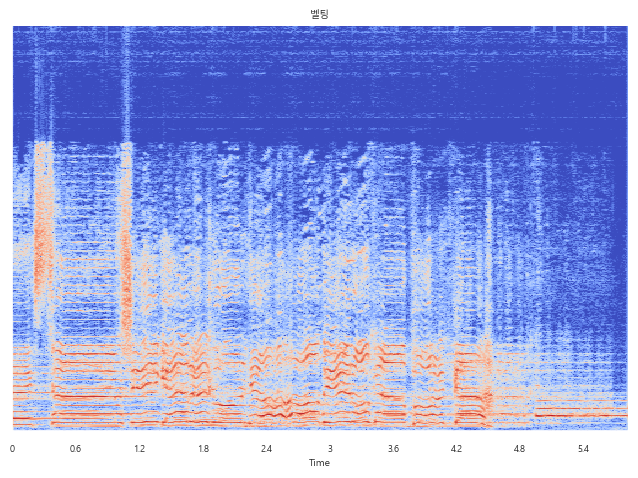

----------


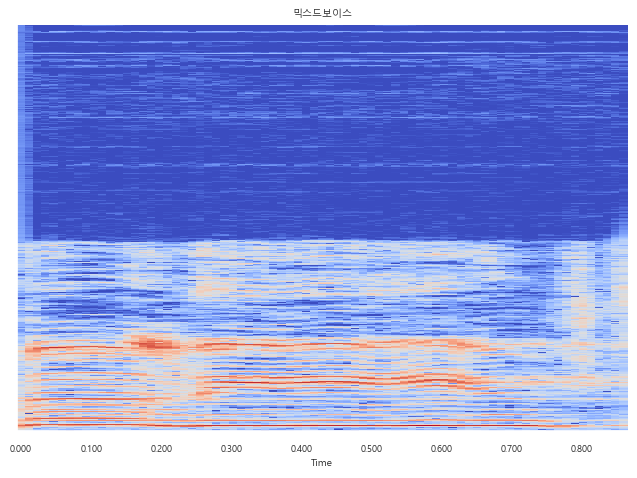

----------


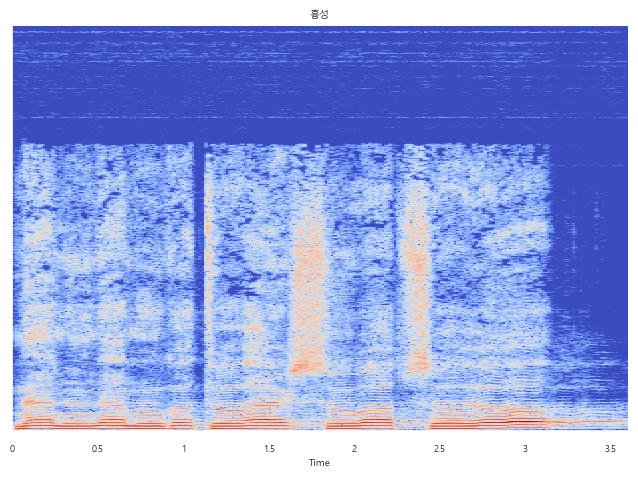

----------


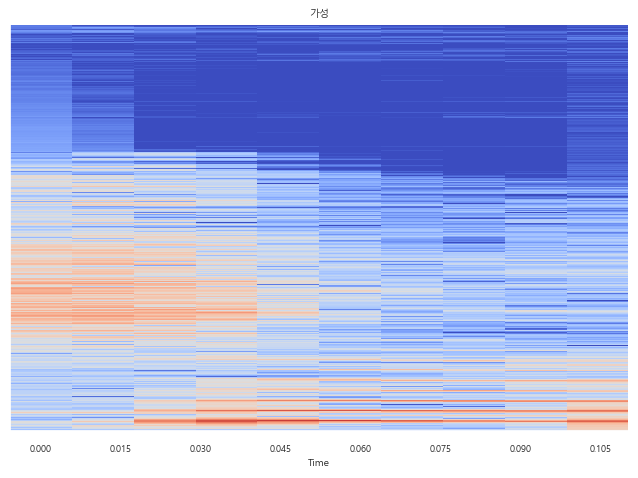

----------


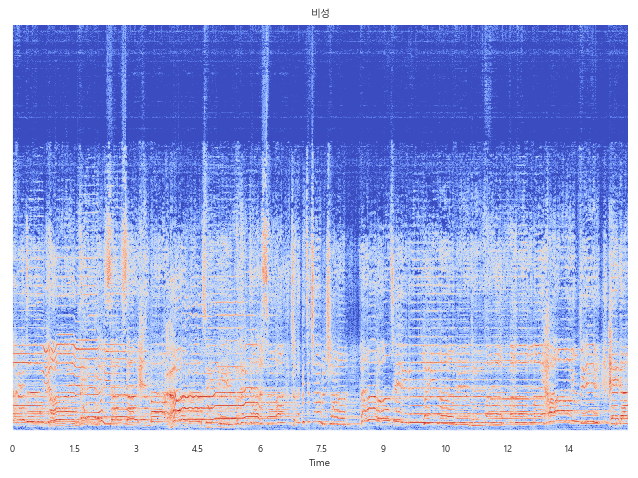

----------


In [220]:
def show_stft(data,idx,name):
  for name_idx,i in enumerate(data):
    ret = librosa.stft(np.array(list(map(float,i[idx]))), n_fft=2048, win_length = 2048, hop_length=512)
    amp = librosa.amplitude_to_db(np.abs(ret))
    show_spec(data = amp, name = name[name_idx])
    print("-"*10)

idx = 10
show_stft(teq_audio,idx,teq)
print("=" * 30)
show_stft(voc_audio,idx,voc)

### 3) Mel

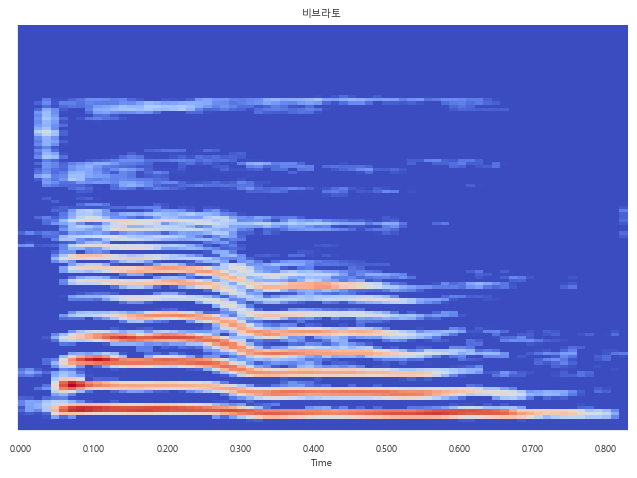

----------


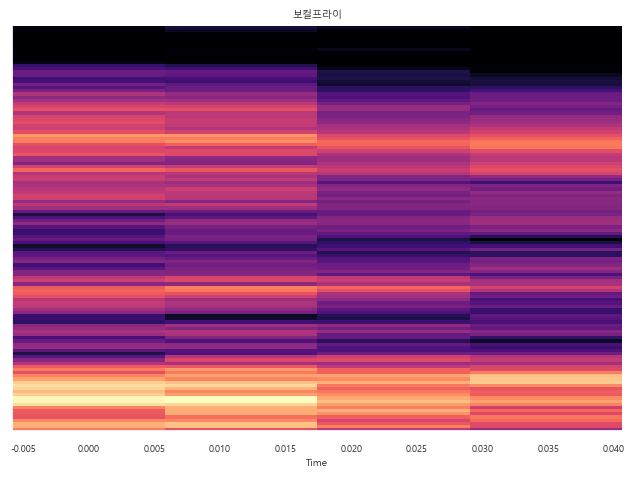

----------


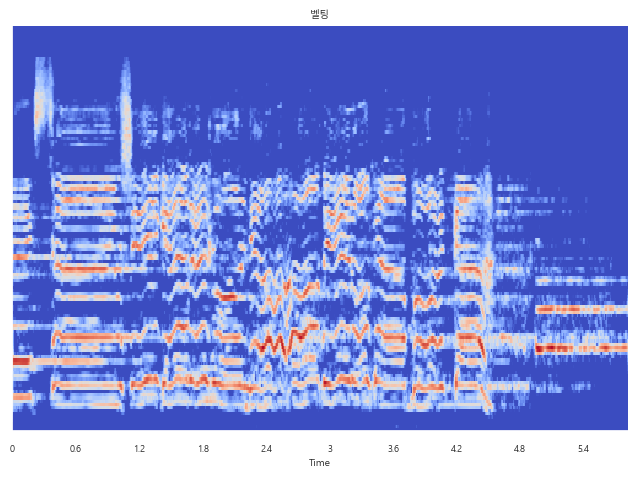

----------


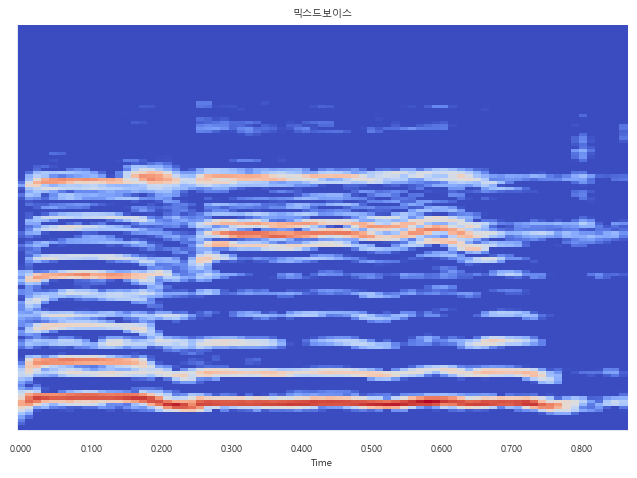

----------


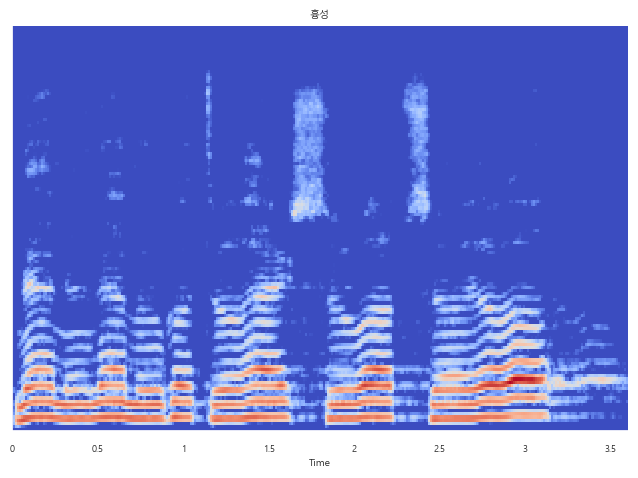

----------


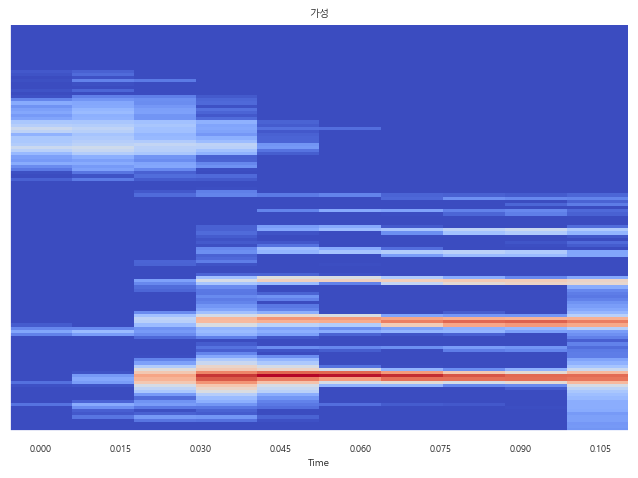

----------


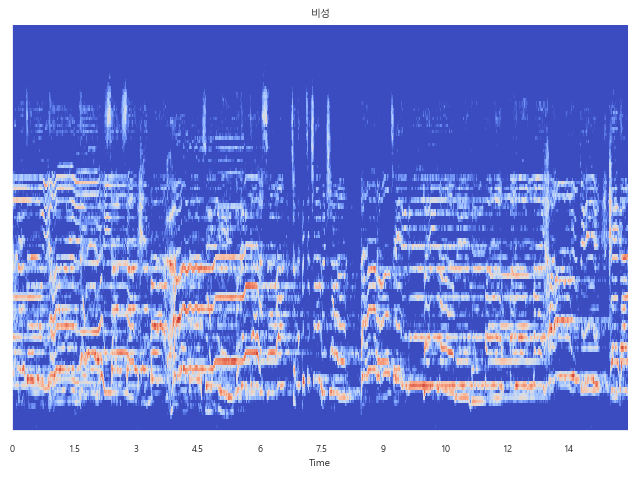

----------


In [221]:
def show_mel(data, idx,name):
  for name_idx,i in enumerate(data):
    ret = librosa.feature.melspectrogram(y = np.array(list(map(float, i[idx]))), sr = 44100)
    amp = librosa.amplitude_to_db(np.abs(ret))
    show_spec(data = amp, name = name[name_idx])
    print("-"*10)
    
idx = 10
show_mel(teq_audio,idx,teq)
print("=" * 30)
show_mel(voc_audio,idx,voc)

### 4. MFCC

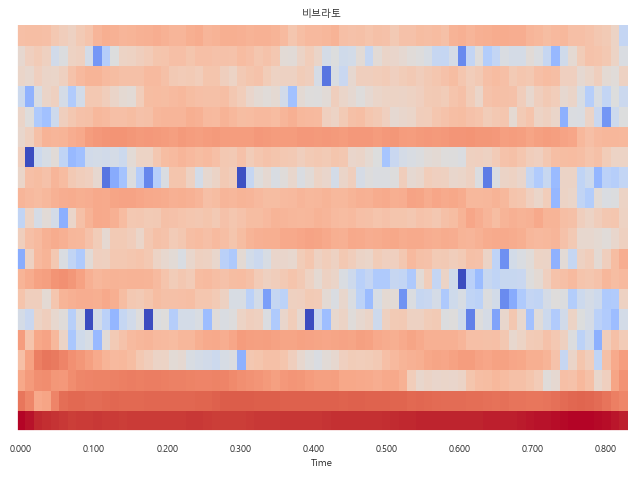

----------


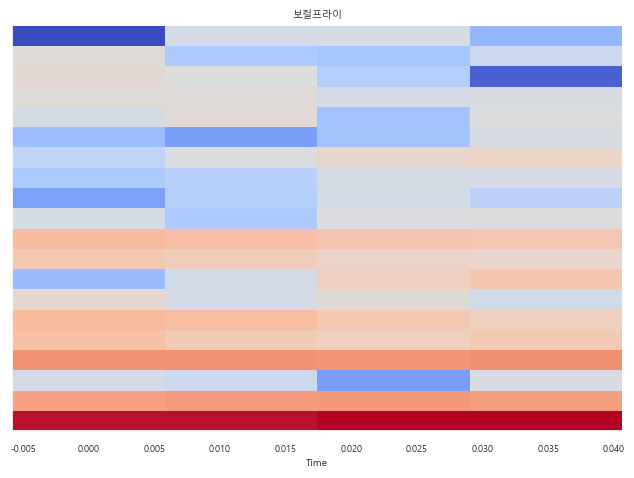

----------


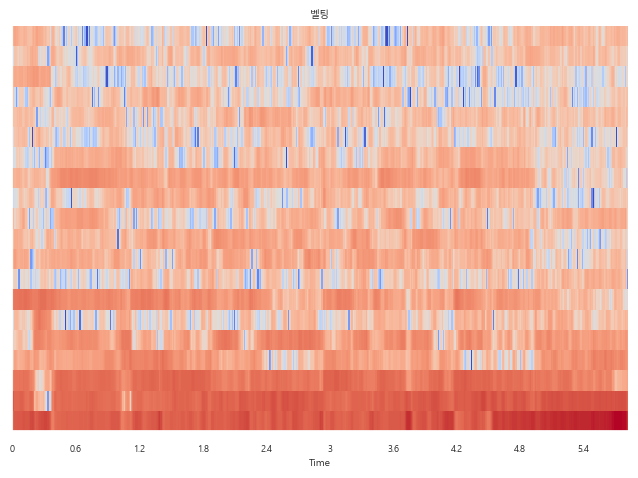

----------


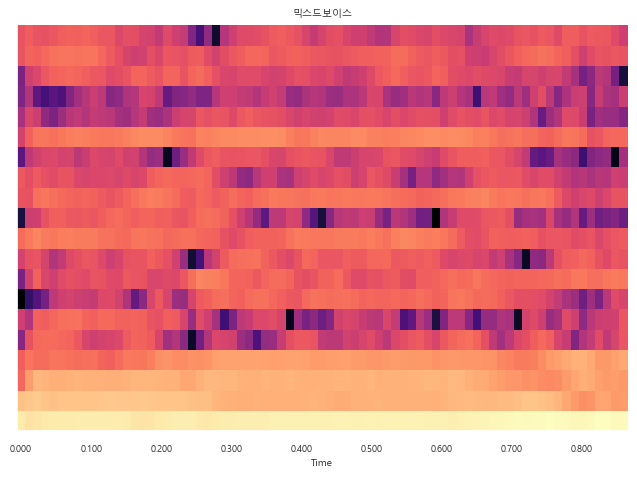

----------


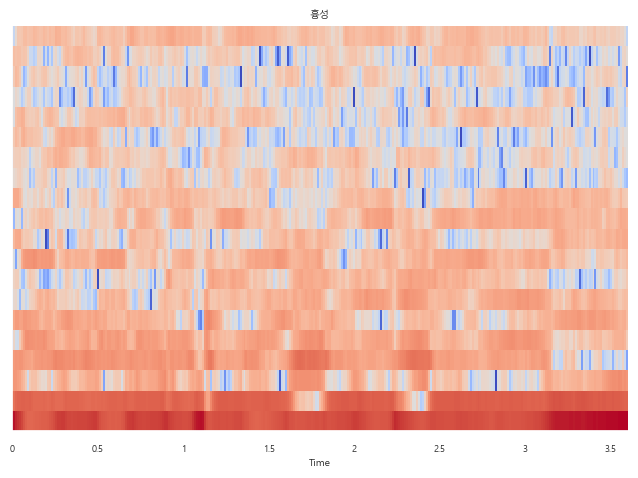

----------


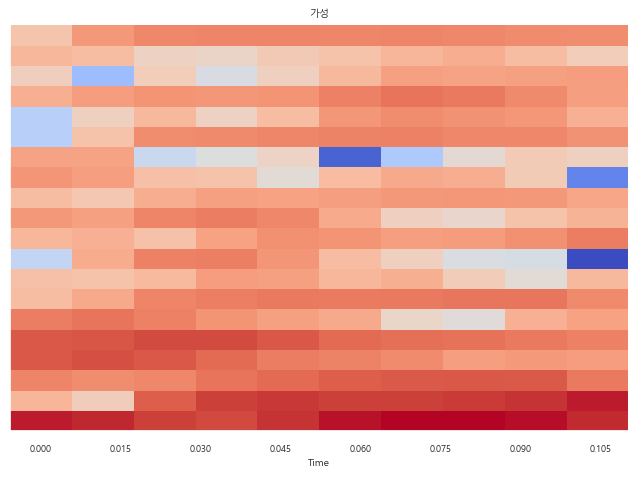

----------


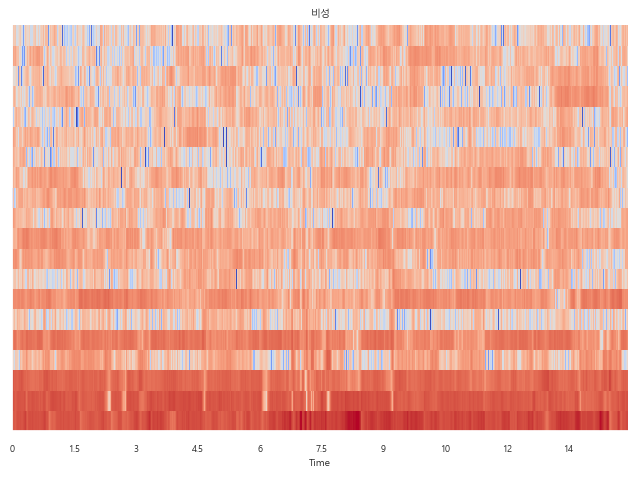

----------


In [222]:
def show_mfcc(data, idx,name):
  for name_idx,i in enumerate(data):
    ret = librosa.feature.mfcc(y = np.array(list(map(float,i[idx]))), sr = 44100, n_mfcc=20)
    amp = librosa.amplitude_to_db(np.abs(ret))
    show_spec(data = amp, name = name[name_idx])
    print("-"*10)
    
idx = 10
show_mfcc(teq_audio,idx,teq)
print("=" * 30)
show_mfcc(voc_audio,idx,voc)

# 정규화

In [1]:
!conda iknst

usage: conda-script.py [-h] [--no-plugins] [-V] COMMAND ...
conda-script.py: error: argument COMMAND: invalid choice: 'iknst' (choose from 'clean', 'compare', 'config', 'create', 'info', 'init', 'install', 'list', 'notices', 'package', 'remove', 'uninstall', 'rename', 'run', 'search', 'update', 'upgrade', 'doctor', 'develop', 'token', 'verify', 'env', 'debug', 'pack', 'index', 'inspect', 'repo', 'metapackage', 'skeleton', 'build', 'convert', 'content-trust', 'render', 'server')


In [ ]:
sr = 44100
path = "C:/Users/Ahn/projects/upsing/copy_song_mr_removed/"
filenames = os.listdir(path)

def split_wav(data, sample_rate, start, end):
    start *= sample_rate
    end *= sample_rate
    return data[int(start):int(end)]

# song['audio_arr'] = np.NaN
for file in filenames:
    data, rate = librosa.load(path + file, sr=sr)
    for idx in song[song['song_name'] == file[:-4]].index:
        trunc_data = split_wav(data, sr, song.loc[idx, 'sec'][0],song.loc[idx, 'sec'][1])
        trunc_data = list(map(float, trunc_data))
        song.at[idx, 'audio_arr'] = np.array(trunc_data, dtype = object)